# Zadania

In [35]:
# Two-class MNIST 

from keras.datasets import mnist
import numpy as np
import sys 

d1 = 5
d2 = 6

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

X_train = (mnist_x_train.astype('float32') / 255.).reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
y_train = mnist_y_train
X_test = (mnist_x_test.astype('float32') / 255.).reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
y_test = mnist_y_test

X_train = X_train[np.logical_or(y_train == d1, y_train == d2)]
y_train = y_train[np.logical_or(y_train == d1, y_train == d2)]
y_train[y_train==d1] = 0
y_train[y_train==d2] = 1
X_test = X_test[np.logical_or(y_test == d1, y_test == d2)]
y_test = y_test[np.logical_or(y_test == d1, y_test == d2)]
y_test[y_test==d1] = 0
y_test[y_test==d2] = 1

print X_train.shape
print X_test.shape


(11339, 784)
(1850, 784)


## Ćwiczenie 1 [5 pkt]

Uzupełnij metody forward_pass oraz backward_pass w klasach ReLU, Sigmoid i Dense. Metoda forward_pass ma przyjmować batch inputów i zwracać batch outputów. Metoda backward_pass ma przyjmować batch inputów oraz batch pochodnych cząstkowych outputów i zwracać batch pochodnych cząstkowych inputów oraz wektor (**nie batch**) pochodnych cząstkowych wag. Jeśli wagi przechowujemy w macierzy dwuwymiarowej, to możemy najpierw policzyć pochodne cząstkowe w macierzy o takim samym kształcie, a następnie np. użyć .flat. 

Uwaga: dla warstw bez wag należy zwrócić None.

## Ćwiczenie 2 [4 pkt]

Uzupełnij metodę _forward_pass klasy Network. Metoda ta ma przyjmować batch inputów (X) i zwracać dwie rzeczy:
* inps - lista batchów inputów dla każdej warstwy w sieci (włącznie z X); te wartości będziemy używali w metodzie _backward_pass
* output - batch outputów z sieci (czyli $\mathbf{\hat y}$); output **nie** powinien być ostatnim elementem inps.

## Ćwiczenie 3 [5 pkt]

Uzupełnij metodę _backward_pass klasy Network. Zwróć uwagę, że pochodna funkcji kosztu po neuronach ostatniej warstwy jest już liczona w metodzie _fit_on_batch. Metoda ma zwracać listę layer_grads, której elementy to wektory pochodnych cząstkowych funkcji kosztu po kolejnych warstwach (zwrócone przez metodę Layer.backward_pass). Kolejność wektorów w tej liście ma być zgodna z kolejnością warstw w sieci.

## Ćwiczenie 4 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą i aktywacją Sigmoid na powyższych danych (dwuklasowy MNIST). Użyj MSE jako funkcji kosztu (oznacza to regresję do numeru klasy, co jest złym pomysłem, ale póki nie mamy klasy Crossentropy musi nam to wystarczyć). Użyj GD. Reportuj loss oraz accuracy.

## Ćwiczenie 5 [3 pkt]
Uzupełnić klasę Crossentropy, wzorując się na klasie MSE.

## Ćwiczenie  6 [3 pkt]
Uzupełnić klasę Momentum, wzorując się na klasie GD. Wzory można znaleźć tutaj: http://distill.pub/2017/momentum/

## Ćwiczenie 7 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą. Rozważ dwa przypadki: aktywację ReLU oraz Sigmoid. Czy jest sens używać ReLU jako ostatnią warstwę? Użyj Crossentropy jako funkcji kosztu. Użyj Momentum. Reportuj loss oraz accuracy.

## Ćwiczenie 8 [6 pkt]
Vanishing gradient.

Zadanie polega na zbadaniu zjawiska *vanishing gradient* w głębokich sieciach. Należy zmodyfikować kod warstwy Dense i dodać monitorowanie **normy euklidesowej** wektora delta_weights. Każdą warstwę Dense w trenowanej sieci należy monitorować oddzielnie. Po każdym wywołaniu metody fit_on_batch każdy z monitorów powinien zapamiętać nową normę. Po nauczeniu sieci dla każdej warstwy należy narysować wykres: poziomo - numer wywołania fit_on_batch, pionowo - norma delta_weights. Im niżej znajduje się warstwa Dense, tym silniej będzie zachodziło zjawisko *vanishing gradient*.

Naucz dwuwarstwową sieć z aktywacjami Sigmoid, reportując normy delta_weights. Powtórz to dla głębszej sieci (np. 6-10 warstw).

## Ćwiczenie 9 [4 pkt]
Przetestować kod z ćwiczenia 7. (dwuwarstwowa sieć) stosując inne inicjalizacje wag w warstwach Dense. Napisać własną inicjalizację wag, która sprawi, że sieć niczego się nie nauczy (init='stupid').


In [60]:
# Warstwy

class Layer():

    def forward_pass(self, input):
        # return output
        raise NotImplementedError()

    def backward_pass(self, input, output_grad):
        # return input_grad, weight_grad
        raise NotImplementedError()

    def update_weights(self, delta_weights):
        pass

    def debug_grad(self, evaluate_loss):
        return None
    
class ReLU(Layer):

    def forward_pass(self, input):
        return np.maximum(0, input)
        
    def backward_pass(self, input, output_grad):
        return np.multiply(output_grad, (np.asmatrix(input) > 0)), None

class Sigmoid(Layer):

    def sigma(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def forward_pass(self, input):
        return self.sigma(input)

    def backward_pass(self, input, output_grad):
        first_multiply = np.multiply(output_grad, self.sigma(input))
        return np.multiply(first_multiply, 1 - self.sigma(input)), None
    
class Dense(Layer):

    def __init__(self, input_size, output_size, init = 'gaussian'):
        input_size += 1
        if init == 'zeros':
            self.weights = np.zeros((input_size, output_size))
        elif init == 'gaussian':
            self.weights = np.random.normal(
                0.,
                2. / (input_size + output_size),
                (input_size, output_size)
            )
        elif init == 'stupid':
            # Ćwiczenie 9
            self.weights = np.full((input_size, output_size), sys.float_info.max)            
        else:
            raise NotImplementedError()
        self.weights = np.asmatrix(self.weights)
        self.delta_norms = []

    def forward_pass(self, input):
        input = np.hstack((np.ones((input.shape[0], 1)), input))
        return np.dot(input, self.weights)
    
    def backward_pass(self, input, output_grad):
        input = np.hstack((np.ones((input.shape[0], 1)), input))
        weight_grad = np.dot(input.T, output_grad)
        input_grad = np.dot(output_grad, self.weights.T)
        return input_grad[:,1:], weight_grad.flat

    def update_weights(self, delta_weights):
        # Ćwiczenie 8 - monitorowanie normy wektora delta_weights
        self.delta_norms.append(np.linalg.norm(delta_weights))
        self.weights += delta_weights.reshape(self.weights.shape)

    def debug_grad(self, evaluate_loss):
        base = evaluate_loss()
        grad = []
        for (x, y), w in np.ndenumerate(self.weights):
            self.weights[x, y] = w + 0.0001
            changed = evaluate_loss()
            grad.append(10000. * (changed - base))
            self.weights[x, y] = w
        return grad

In [12]:
# Optimizers

class Optimizer():

    def calculate_deltas(self, grad):
        raise NotImplementedError()

class GD(Optimizer):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def calculate_deltas(self, grad):
        return -self.learning_rate * grad

class Momentum(Optimizer):

    def __init__(self, alpha, beta):
         # Ćwiczenie 6
        self.alpha = alpha
        self.beta = beta
        self.z = 0
        
    def calculate_deltas(self, grad):
         # Ćwiczenie 6 
        self.z = self.beta * self.z + grad
        return -self.alpha * self.z
        

In [13]:
# Funkcje kosztu

class Loss():

    def forward_pass(self, y, t):
        # return cost
        raise NotImplementedError()

    def backward_pass(self, y, t):
        # return y_grad
        raise NotImplementedError()

class MSE(Loss):

    def forward_pass(self, y, t):
        return np.average(0.5 * np.square(y - t))

    def backward_pass(self, y, t):
        return (y - t) / y.size

class Crossentropy(Loss):

    def forward_pass(self, y, t):
        # Ćwiczenie 5
        return np.average(np.multiply(- t, np.log(y)) - np.multiply(1 - t, np.log(1 - y)))
        
    def backward_pass(self, y, t):
        # Ćwiczenie 5
        return (-t/y + ((1 - t)/(1 - y)))/ y.size

In [14]:
class Network():

    def __init__(self, loss, optimizer, metrics = []):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics

    def add(self, layer):
        self.layers.append(layer)

    def fit(self, X, t, epochs, batch_size=256, print_stats=False):
        X = np.array(X)
        t = np.array(t)
        X = X.reshape(len(X), -1)
        t = t.reshape(len(t), -1)
        if X.shape[0] != t.shape[0]:
            raise ValueError("Array sizes don't match")

        for epoch in range(epochs):
            if print_stats:
                print("Epoch %d" % (epoch+1))
                print("    -> batch size: %d" % batch_size)
            rng_state = np.random.get_state()
            np.random.shuffle(X)
            np.random.set_state(rng_state)
            np.random.shuffle(t)
            pos = 0
            while pos < len(X):
                batch_X = X[pos:pos+batch_size]
                batch_t = t[pos:pos+batch_size]
                self._fit_on_batch(batch_X, batch_t)
                pos += batch_size
            if print_stats:
                _, y = self._forward_pass(X)
                l = self.loss.forward_pass(y, t)
                print("    -> loss: %f" % l)
                for m in self.metrics:
                    print("    -> %s: %f" % (m.__name__, m(y, t)))

    def predict(self, X):
        inps, out = self._forward_pass(X)
        return out

    def _fit_on_batch(self, batch_X, batch_t):
        inps, out = self._forward_pass(batch_X)
        layer_grads = self._backward_pass(
            inps,
            self.loss.backward_pass(out, batch_t)
        )
        grad = self._join(layer_grads)
        deltas = self.optimizer.calculate_deltas(grad)
        for l, d in zip(self.layers, self._split(deltas, layer_grads)):
            if not d is None:
                l.update_weights(d)

    def _join(self, grads):
        return np.concatenate([g for g in grads if not g is None])

    def _split(self, grads, layer_grads):
        out = []
        start = 0
        for l in layer_grads:
            if l is None:
                out.append(None)
            else:
                out.append(grads[start:start+len(l)])
                start += len(l)
        return out

    def _forward_pass(self, X):
        # Ćwiczenie 2
        inps = [X]
        output = None
        for i, layer in enumerate(self.layers):
            next_input = layer.forward_pass(inps[i])
            if (i == len(self.layers) - 1):
                output = next_input
            else:
                inps.append(next_input)
        #make output binary
        output = np.asmatrix(output) > 0.5
        return inps, output
    
    def _backward_pass(self, inps, grad):
        # Ćwiczenie 3
        layer_grads = []
        back_inps = list(reversed(inps))
        back_layers = list(reversed(self.layers))
        output_grad = grad
        for i, layer in enumerate(back_layers):
            if (i != 0):
                output_grad, weights = layer.backward_pass(back_inps[i], output_grad)
                layer_grads.append(weights)
        layer_grads = list(reversed(layer_grads))
        return layer_grads

    
    def _debug_grads(self, X, t):
        layer_grads = []
        for l in self.layers:
            g = l.debug_grad(
                lambda: self.loss.forward_pass(self._forward_pass(X)[1], t)
            )
            if not g is None:
                g = np.array(np.array(g).flat)
            layer_grads.append(g)
        return layer_grads

In [61]:
# Ćwiczenie 4
from sklearn.metrics import accuracy_score
n = 100
network = Network(MSE(), GD(0.1), [accuracy_score])
network.add(Dense(X_train.shape[1] , n))
network.add(Sigmoid())
network.add(Dense(n, 1))
network.add(Sigmoid())

network.fit(X_train, y_train, 5, batch_size = 100, print_stats=True)

Epoch 1
    -> batch size: 100
    -> loss: 0.239042
    -> accuracy_score: 0.521916
Epoch 2
    -> batch size: 100
    -> loss: 0.239042
    -> accuracy_score: 0.521916
Epoch 3
    -> batch size: 100
    -> loss: 0.239042
    -> accuracy_score: 0.521916
Epoch 4
    -> batch size: 100
    -> loss: 0.239042
    -> accuracy_score: 0.521916
Epoch 5
    -> batch size: 100
    -> loss: 0.239042
    -> accuracy_score: 0.521916


In [8]:
# Ćwiczenie 7
def trainNetwork(activity_layer):
    n = 100
    network = Network(Crossentropy(), Momentum(alpha=0.02, beta=0.99), [accuracy_score])
    network.add(Dense(X_train.shape[1] , n))
    network.add(activity_layer)
    network.add(Dense(n, 1))
    network.add(activity_layer)
    network.fit(X_train, y_train, 3, batch_size = 100, print_stats=True)
    
print "Sigmoid :"
trainNetwork(Sigmoid())
print "ReLU :"
trainNetwork(ReLU())

Sigmoid :
Epoch 1
    -> batch size: 100
[[ -3.08921298e-03   5.60540774e-04  -1.36867988e-03 ...,  -3.60036867e-03
   -4.29727133e-04   1.03007967e-03]
 [ -9.74224097e-05  -4.08314330e-03   4.94239909e-04 ...,  -2.08231723e-03
    2.87553549e-03  -3.02542424e-03]
 [  7.54450070e-04  -2.05495055e-03   8.31539296e-04 ...,  -2.06754720e-03
    2.16348233e-03  -1.04736012e-03]
 ..., 
 [ -2.01276596e-03   1.05669713e-03   8.92326511e-04 ...,   5.72376829e-04
    3.08687319e-04  -6.36246622e-04]
 [  7.59271212e-04  -4.13559575e-03  -2.32851038e-03 ...,  -7.80349404e-04
   -1.33544801e-03   2.36337488e-03]
 [  9.06105701e-05  -1.56533859e-03  -2.44431868e-03 ...,   2.46010345e-03
    4.19983348e-03  -2.60580489e-03]]
[[ 0.02536353]
 [-0.02217108]
 [-0.01686939]
 [-0.02254968]
 [-0.00333285]
 [ 0.0070823 ]
 [ 0.00671613]
 [-0.02068528]
 [ 0.02806929]
 [-0.00126778]
 [-0.01622131]
 [-0.00737305]
 [-0.00279595]
 [-0.0008199 ]
 [ 0.0043036 ]
 [ 0.02937222]
 [-0.04209633]
 [-0.00440755]
 [ 0.0007

/Users/anna-maria/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in divide


[[  1.08284894e-01   8.52966808e-02   1.11897747e-01 ...,  -1.01346604e-01
    2.24249183e-01  -1.49867842e-02]
 [ -9.74224097e-05  -4.08314330e-03   4.94239909e-04 ...,  -2.08231723e-03
    2.87553549e-03  -3.02542424e-03]
 [  7.54450070e-04  -2.05495055e-03   8.31539296e-04 ...,  -2.06754720e-03
    2.16348233e-03  -1.04736012e-03]
 ..., 
 [ -2.01276596e-03   1.05669713e-03   8.92326511e-04 ...,   5.72376829e-04
    3.08687319e-04  -6.36246622e-04]
 [  7.59271212e-04  -4.13559575e-03  -2.32851038e-03 ...,  -7.80349404e-04
   -1.33544801e-03   2.36337488e-03]
 [  9.06105701e-05  -1.56533859e-03  -2.44431868e-03 ...,   2.46010345e-03
    4.19983348e-03  -2.60580489e-03]]
[[-20.06969166]
 [-10.03955621]
 [ -9.98170636]
 [ -9.96830706]
 [-10.13148912]
 [-10.09605512]
 [-10.1240341 ]
 [-10.15678953]
 [ -9.94918318]
 [ -9.95086105]
 [ -9.84682369]
 [-10.01303413]
 [-10.09604993]
 [-10.0788297 ]
 [-10.16106143]
 [-10.10291571]
 [-10.06039287]
 [-10.05846241]
 [-10.02286685]
 [-10.0244088 ]


/Users/anna-maria/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp


[[  2.33338599e-01   1.80440594e-01   2.39076199e-01 ...,  -2.11098586e-01
    4.76524430e-01  -3.29709301e-02]
 [ -9.74224097e-05  -4.08314330e-03   4.94239909e-04 ...,  -2.08231723e-03
    2.87553549e-03  -3.02542424e-03]
 [  7.54450070e-04  -2.05495055e-03   8.31539296e-04 ...,  -2.06754720e-03
    2.16348233e-03  -1.04736012e-03]
 ..., 
 [ -2.01276596e-03   1.05669713e-03   8.92326511e-04 ...,   5.72376829e-04
    3.08687319e-04  -6.36246622e-04]
 [  7.59271212e-04  -4.13559575e-03  -2.32851038e-03 ...,  -7.80349404e-04
   -1.33544801e-03   2.36337488e-03]
 [  9.06105701e-05  -1.56533859e-03  -2.44431868e-03 ...,   2.46010345e-03
    4.19983348e-03  -2.60580489e-03]]
[[-42.63293547]
 [-21.28733339]
 [-21.17048111]
 [-21.13565878]
 [-21.50364298]
 [-21.44011718]
 [-21.49910053]
 [-21.53786759]
 [-21.15189838]
 [-21.12251979]
 [-20.8848764 ]
 [-21.24764724]
 [-21.4290146 ]
 [-21.39467782]
 [-21.57499424]
 [-21.47970871]
 [-21.30919341]
 [-21.34741329]
 [-21.2776153 ]
 [-21.29860997]


/Users/anna-maria/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
/Users/anna-maria/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in multiply


[[  7.26045540e-01   5.55304067e-01   7.40154560e-01 ...,  -6.43517306e-01
    1.47047950e+00  -1.03827795e-01]
 [ -9.74224097e-05  -4.08314330e-03   4.94239909e-04 ...,  -2.08231723e-03
    2.87553549e-03  -3.02542424e-03]
 [  7.54450070e-04  -2.05495055e-03   8.31539296e-04 ...,  -2.06754720e-03
    2.16348233e-03  -1.04736012e-03]
 ..., 
 [ -2.01276596e-03   1.05669713e-03   8.92326511e-04 ...,   5.72376829e-04
    3.08687319e-04  -6.36246622e-04]
 [  7.59271212e-04  -4.13559575e-03  -2.32851038e-03 ...,  -7.80349404e-04
   -1.33544801e-03   2.36337488e-03]
 [  9.06105701e-05  -1.56533859e-03  -2.44431868e-03 ...,   2.46010345e-03
    4.19983348e-03  -2.60580489e-03]]
[[-131.53127522]
 [ -65.6031563 ]
 [ -65.25383664]
 [ -65.13460834]
 [ -66.30950537]
 [ -66.13529892]
 [ -66.31643833]
 [ -66.37889099]
 [ -65.29017877]
 [ -65.13843889]
 [ -64.37439272]
 [ -65.51160421]
 [ -66.08047305]
 [ -65.97869767]
 [ -66.54546413]
 [ -66.30384913]
 [ -65.62904831]
 [ -65.82545905]
 [ -65.6209047

 Czy jest sens używać ReLU jako ostatnią warstwę?
 
 Odpowiedź: Nie ma sensu używać ReLU jako ostatnią warstwę. Chociaż ReLU jest najbardziej popularną funckcją aktywacyjną, ale akurat w tym przypadku ona odrzuci informację i nie przyniesie żadnej dodakowej wygody.

Epoch 1
    -> batch size: 100


/Users/anna-maria/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp


    -> loss: 0.260958
    -> accuracy_score: 0.478084


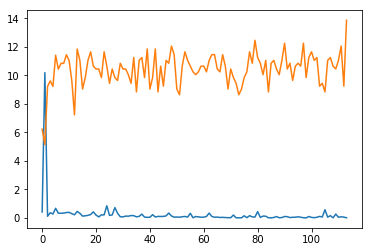

In [21]:
# Ćwiczenie 8
import matplotlib.pyplot as plt

n = 100
def trainNetworkVanGrad(dense_layers):
    network = Network(MSE(), GD(0.01), [accuracy_score])

    activity_layer = Sigmoid()
    for d_layer in dense_layers:
        network.add(d_layer)
        network.add(activity_layer)
    network.fit(X_train, y_train, 1, batch_size = 100, print_stats=True)
    
    for i, d_layer in enumerate(dense_layers): 
        delta_norms = d_layer.delta_norms
        label = "dense layer %s" % i
        plt.plot(range(len(delta_norms)), delta_norms, label = label)
    plt.show()
       
dense_layers_2 = [Dense(X_train.shape[1] , n), Dense(n, 1)]
trainNetworkVanGrad(dense_layers_2)

Epoch 1
    -> batch size: 100


/Users/anna-maria/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp


    -> loss: 0.260958
    -> accuracy_score: 0.478084


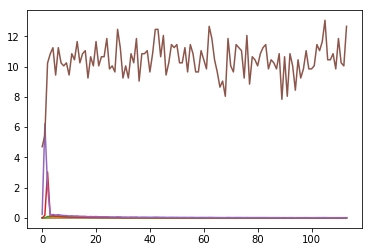

In [24]:
dense_layers_6 = [Dense(X_train.shape[1] , n), Dense(n, n), Dense(n, n), Dense(n, n), Dense(n, n), Dense(n, 1)]
trainNetworkVanGrad(dense_layers_6)

In [53]:
# Ćwiczenie 9
def trainNetworkD(activity_layer, init_dense):
    n = 100
    network = Network(MSE(), Momentum(alpha=0.02, beta=0.99), [accuracy_score])
    network.add(Dense(X_train.shape[1] , n, init_dense))
    network.add(activity_layer)
    network.add(Dense(n, 1, init_dense))
    network.add(activity_layer)
    network.fit(X_train, y_train, 3, batch_size = 100, print_stats=True)
    
# print "Sigmoid gaussian :"
# trainNetworkD(Sigmoid(), 'gaussian')
# print "ReLU gaussian:"
# trainNetworkD(ReLU(), 'gaussian')
# print "Sigmoid zeros:"
# trainNetworkD(Sigmoid(), 'zeros')
# print "ReLU zeros:"
# trainNetworkD(ReLU(), 'zeros')
print "Sigmoid stupid:"
trainNetworkD(Sigmoid(), 'stupid')
print "ReLU stupid:"
trainNetworkD(ReLU(), 'stupid')

Sigmoid stupid:
Epoch 1
    -> batch size: 100
    -> loss: 0.239042
    -> accuracy_score: 0.521916
Epoch 2
    -> batch size: 100
    -> loss: 0.239042
    -> accuracy_score: 0.521916
Epoch 3
    -> batch size: 100
    -> loss: 0.239042
    -> accuracy_score: 0.521916
ReLU stupid:
Epoch 1
    -> batch size: 100


/Users/anna-maria/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:82: RuntimeWarning: invalid value encountered in greater
/Users/anna-maria/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater


    -> loss: 0.260958
    -> accuracy_score: 0.478084
Epoch 2
    -> batch size: 100
    -> loss: 0.260958
    -> accuracy_score: 0.478084
Epoch 3
    -> batch size: 100
    -> loss: 0.260958
    -> accuracy_score: 0.478084
